In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import pickle

# Load dataset

In [2]:
df = pd.read_csv('UpdatedResumeDataSet.csv')
df

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


# Visualisasi data

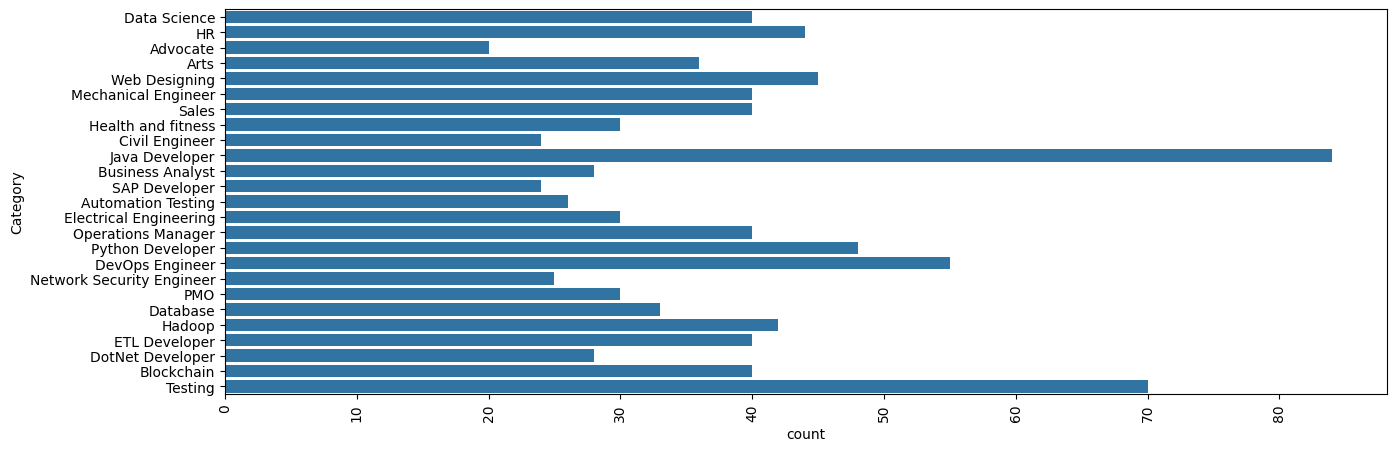

In [3]:
plt.figure(figsize=(15,5))
sns.countplot(df['Category'])
plt.xticks(rotation=90)
plt.show()

# Cleaing feature

In [4]:
def cleanResume(txt):
    cleanText = re.sub('http\S+\s', ' ', txt)
    cleanText = re.sub('RT|cc', ' ', cleanText)
    cleanText = re.sub('#\S+\s', ' ', cleanText)
    cleanText = re.sub('@\S+', '  ', cleanText)  
    cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText) 
    cleanText = re.sub('\s+', ' ', cleanText)
    return cleanText

df['Clean_Resume'] = df['Resume'].apply(cleanResume)
df

,Category,Resume,Clean_Resume
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...
...,...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...,Computer Skills Proficient in MS office Word B...
958,Testing,â Willingness to accept the challenges. â ...,Willingness to a ept the challenges Positive ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",PERSONAL SKILLS Quick learner Eagerness to lea...
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,COMPUTER SKILLS SOFTWARE KNOWLEDGE MS Power Po...


In [19]:
le = LabelEncoder()
le.fit(df['Category'])
df['Category'] = le.transform(df['Category'])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['Clean_Resume'], df['Category'], test_size=0.2, random_state=42)

# Cek distribusi kategori di training dan testing
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Training set size: (1680,), Test set size: (420,)


# Balancing Data: Oversampling (Oversampling Category)


In [ ]:
# Cek distribusi kategori sebelum oversampling
print("Original Category Distribution:")
print(y_train.value_counts())
max_size = y_train.value_counts().max() # Tentukan ukuran kategori terbesar

# Oversampling: perbanyak sampel berdasarkan kategori yang ada
balanced_df = df.groupby('Category').apply(lambda x: x.sample(max_size, replace=True)).reset_index(drop=True)

# Shuffle dataset untuk menghindari bias urutan
df = balanced_df.sample(frac=1).reset_index(drop=True)

# Cek distribusi kategori setelah oversampling
print("\nBalanced Category Distribution (After Oversampling):")
print(df['Category'].value_counts())

Original Category Distribution:
Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager           40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64

Balanced Category Distribution (After Oversampling):
Category
Sales                        84
Data Science                 84
SAP De

C:\Users\Ary\AppData\Local\Temp\ipykernel_18484\3464199357.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('Category').apply(lambda x: x.sample(max_size, replace=True)).reset_index(drop=True)


# Vactorization

In [7]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(df['Clean_Resume'])
requredTaxt  = tfidf.transform(df['Clean_Resume'])

# Hyperparameter Optimization (HPO), Evaluation and Confusion Matrix

In [9]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# 1. GridSearchCV untuk KNN
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

# 2. GridSearchCV untuk Random Forest
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# 3. GridSearchCV untuk SVC
svc = SVC(probability=True, random_state=42)
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train, y_train)

# Menampilkan hasil terbaik dari setiap model
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best parameters for SVC:", grid_search_svc.best_params_)


Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for SVC: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [10]:
# Evaluasi model terbaik pada testing set
# 1. KNN
y_pred_knn = grid_search_knn.predict(X_test)
print("\nClassification Report for KNN:\n", classification_report(y_test, y_pred_knn))


Classification Report for KNN:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        14
           8       1.00      0.89      0.94        18
           9       1.00      1.00      1.00        21
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        22
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00     

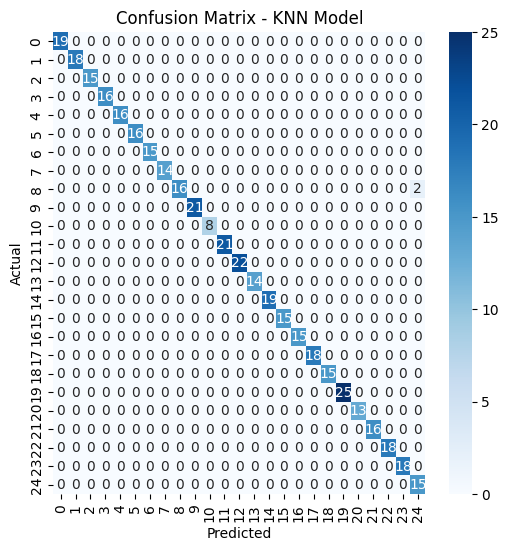

In [11]:
# Plot Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df['Category']), yticklabels=np.unique(df['Category']))
plt.title("Confusion Matrix - KNN Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
# Evaluasi model terbaik pada testing set
# 2. Random Forest
y_pred_rf = grid_search_rf.predict(X_test)
print("\nClassification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))


Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        21
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        22
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        15
          16       1.00      1.00     

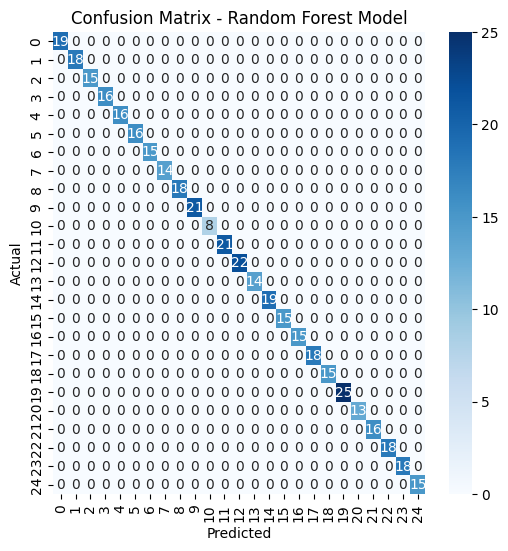

In [13]:
# Plot Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df['Category']), yticklabels=np.unique(df['Category']))
plt.title("Confusion Matrix - Random Forest Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [14]:
# Evaluasi model terbaik pada testing set
# 3. SVC
confidence_scores = grid_search_svc.predict_proba(X_test) # Get confidence scores
y_pred_svc = grid_search_svc.predict(X_test)
print("\nClassification Report for SVC:\n", classification_report(y_test, y_pred_svc))


Classification Report for SVC:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        21
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        22
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00     

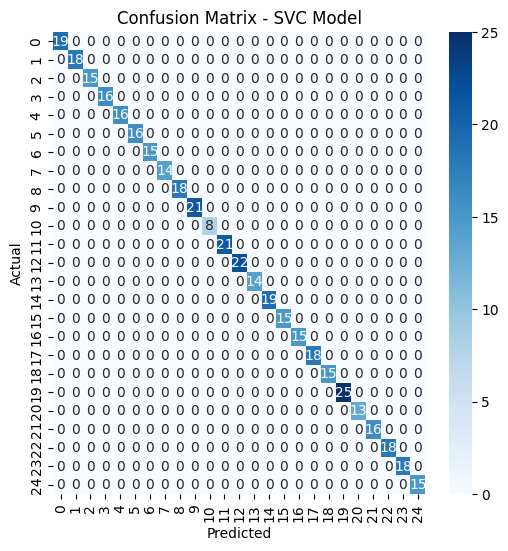

In [15]:
# Plot Confusion Matrix for SVC
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df['Category']), yticklabels=np.unique(df['Category']))
plt.title("Confusion Matrix - SVC Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save Model

In [16]:
pickle.dump(tfidf,open('tfidf_vactorizer.pkl','wb'))
pickle.dump(grid_search_svc, open('svc_model_clf.pkl', 'wb'))
pickle.dump(le, open("label_encoder.pkl",'wb'))